<img src="files/model_1_outline.png">

sequence generator shape (corrected) (b, n, w, h, c)

## Changes: 
### Use camera 2
### Trim to 2 seconds

In [46]:
import os
import glob
import keras

In [48]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
import tensorflow as tf
import datetime
tf.test.is_gpu_available()

True

In [50]:
tf.__version__

'2.1.0'

In [8]:
classes = ['suture_throws', 'hand_ties', 'thread_cuts']
classes.sort()
print(classes)

['hand_ties', 'suture_throws', 'thread_cuts']


In [9]:
# some global params
SIZE = (100, 100) # height and width of frame pxl by pxl
CHANNELS = 3 # RGB or whatever
NBFRAME = 5 # num frames in sequence 
BS = 8 # Batch size

In [36]:
# pattern to get videos and classes
#glob_pattern='../data_v3_model_2.2/model_data/{classname}/*.avi'
glob_pattern = r"C:\Users\calvinap\Box\Pugh Lab Shared Drive\Temp files\data_v2_1_model_1_2\model_data\{classname}\*.avi"

In [37]:
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

In [38]:
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

class hand_ties, validation count: 129, train count: 264
class suture_throws, validation count: 129, train count: 264
class thread_cuts, validation count: 129, train count: 264
Total data: 3 classes for 792 files for train


In [39]:
# getting validation data
valid = train.get_validation_generator()

Total data: 3 classes for 387 files for validation


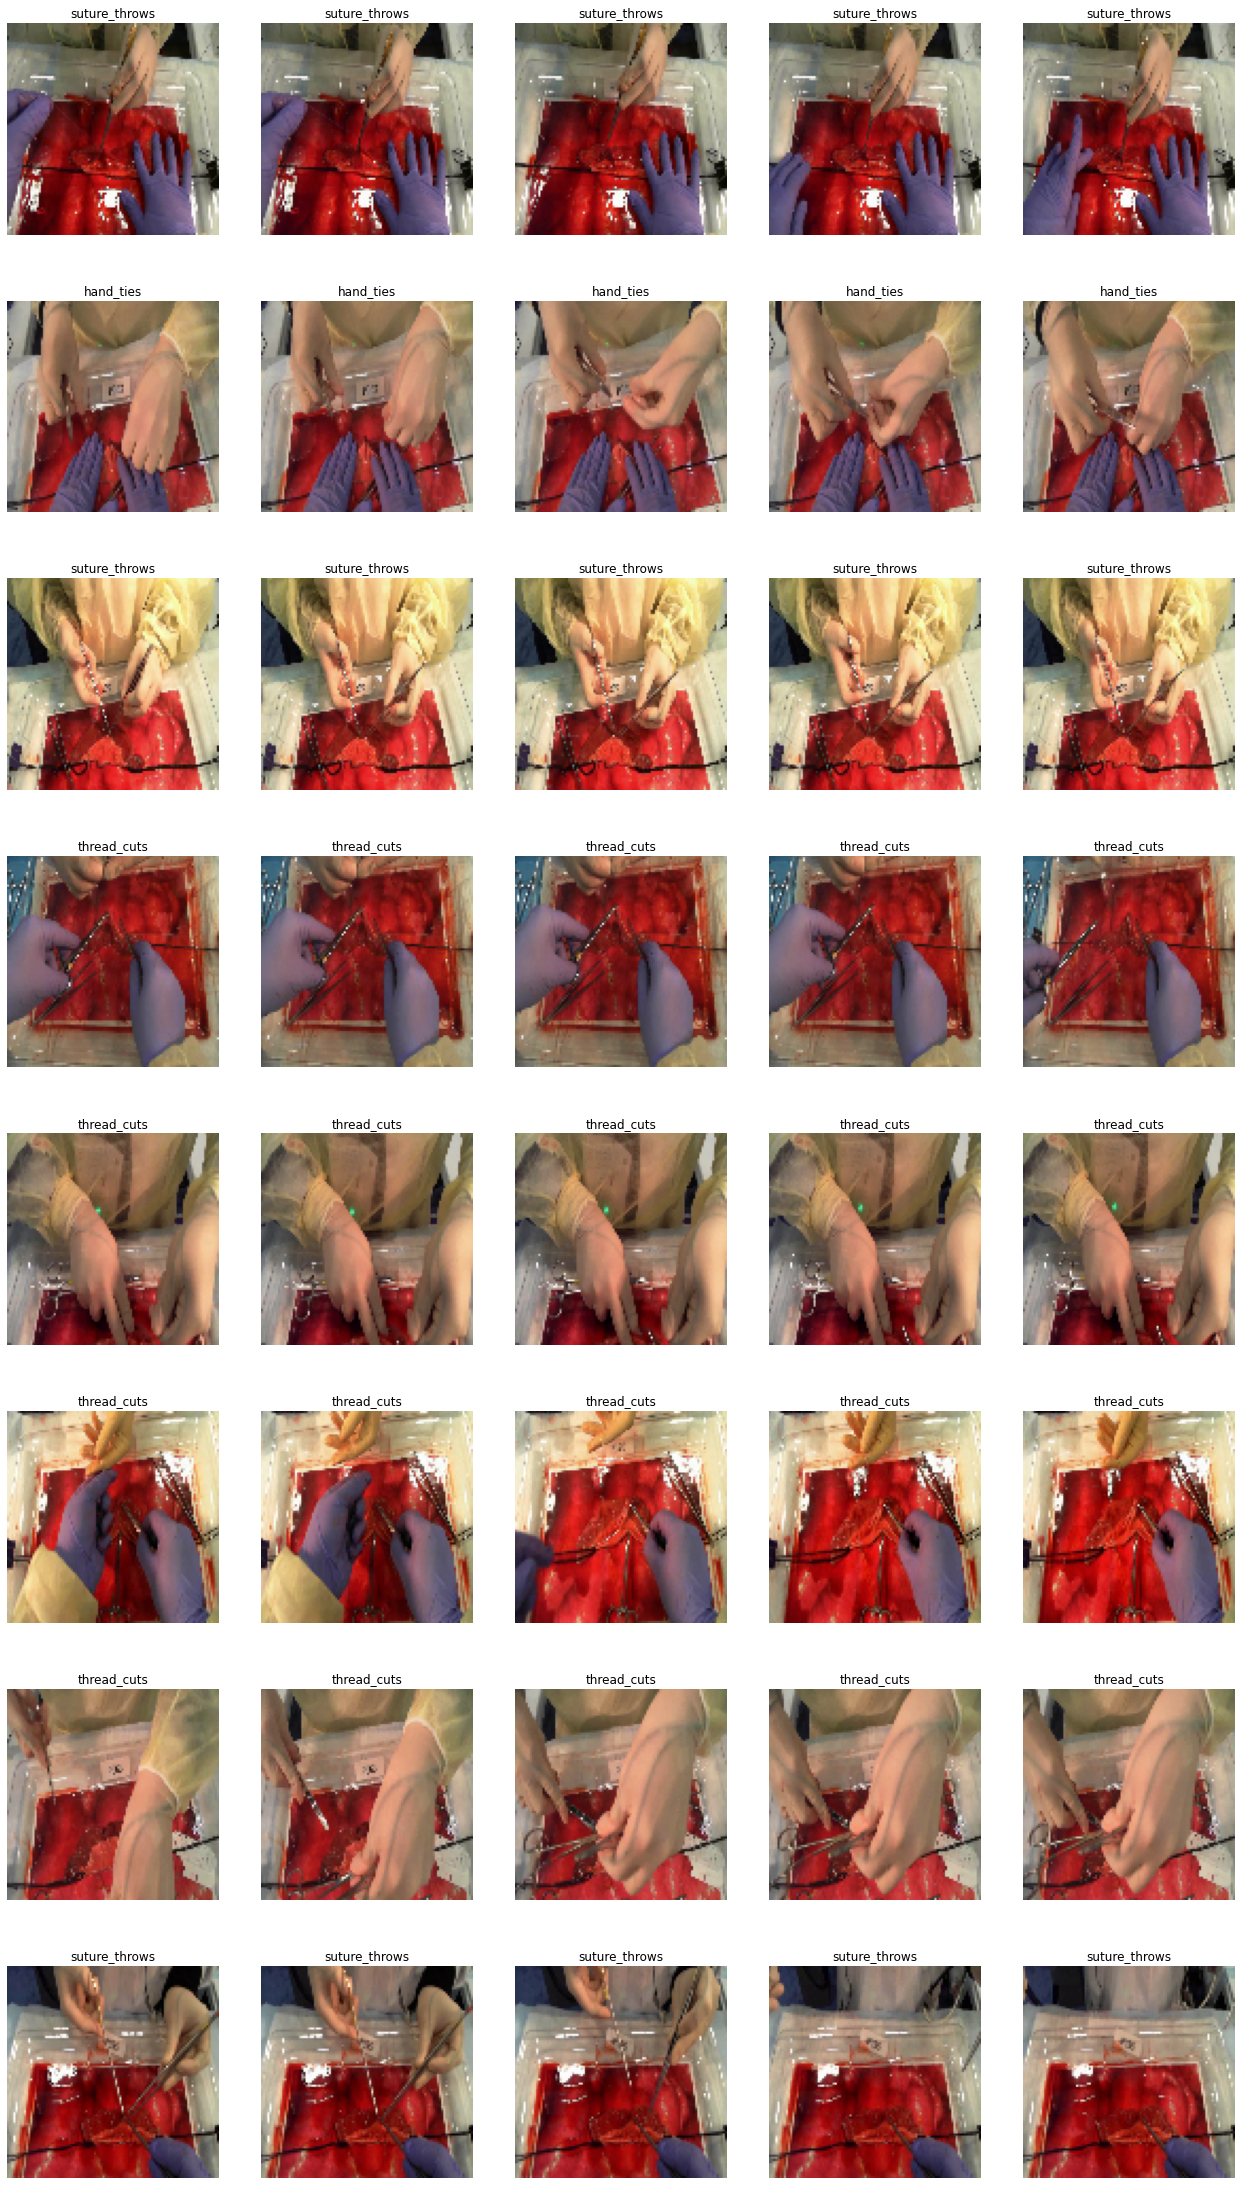

In [40]:
import keras_video.utils
keras_video.utils.show_sample(train)

## BUILD CONV NET

In [41]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_mobilenet(shape=(224, 224, 3), nbout=3):
    model = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    # Keep 9 layers to train﻿﻿
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return keras.Sequential([model, output])

## Build GRU

In [42]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
# Shape (5, 112, 112, 3) 5 - time sequence length 112x112 = height vs width 3 - num channels
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    # KEY = allows you to add a time sequence to a layer one at a time
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

## this is where you tell the model how to train - loss function, weight update mechanism

In [43]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
# action model - GRU set up for Time shifted CNN
model = action_model(INSHAPE, len(classes))

# this is where you tell the model how to train - loss function, weight update mechanism
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

C:\Users\calvinap\miniconda3\envs\tensorflow\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


## epochs, call backs

In [44]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [45]:
EPOCHS=100
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        os.path.join(r"C:\Users\calvinap\SUMER-VID\jupyter notebooks", r"model2_0_chkp\weights.{epoch:02d}-{val_loss:.2f}.hdf5"),
        verbose=1),
]
model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
99/99 [==============================] - 1184s 12s/step - loss: 1.1533 - acc: 0.3321 - val_loss: 1.0924 - val_acc: 0.3333

Epoch 00001: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.01-1.09.hdf5
Epoch 2/100
99/99 [==============================] - 5s 50ms/step - loss: 1.1389 - acc: 0.3157 - val_loss: 1.1043 - val_acc: 0.3333

Epoch 00002: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.02-1.10.hdf5
Epoch 3/100
99/99 [==============================] - 2s 17ms/step - loss: 1.1149 - acc: 0.3270 - val_loss: 1.0984 - val_acc: 0.3333

Epoch 00003: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.03-1.10.hdf5
Epoch 4/100
99/99 [==============================] - 2s 17ms/step - loss: 1.1107 - acc: 0.3384 - val_loss: 1.0907 - val_acc: 0.3307

Epoch 00004: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.04-1.09.hdf5
Epoch 5/100
99/99 [=======

99/99 [==============================] - 2s 17ms/step - loss: 1.0997 - acc: 0.3081 - val_loss: 1.0982 - val_acc: 0.3333

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00034: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.34-1.10.hdf5
Epoch 35/100
99/99 [==============================] - 2s 18ms/step - loss: 1.0980 - acc: 0.3434 - val_loss: 1.0974 - val_acc: 0.3359

Epoch 00035: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.35-1.10.hdf5
Epoch 36/100
99/99 [==============================] - 2s 17ms/step - loss: 1.0984 - acc: 0.3447 - val_loss: 1.0974 - val_acc: 0.3333

Epoch 00036: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.36-1.10.hdf5
Epoch 37/100
99/99 [==============================] - 2s 17ms/step - loss: 1.1010 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333

Epoch 00037: saving model to C:\Users\calvinap\SUMER-VID\jupyter 

99/99 [==============================] - 2s 18ms/step - loss: 1.1002 - acc: 0.3371 - val_loss: 1.0981 - val_acc: 0.3281

Epoch 00066: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.66-1.10.hdf5
Epoch 67/100
99/99 [==============================] - 2s 17ms/step - loss: 1.0997 - acc: 0.3422 - val_loss: 1.0983 - val_acc: 0.3359

Epoch 00067: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.67-1.10.hdf5
Epoch 68/100
99/99 [==============================] - 2s 17ms/step - loss: 1.0994 - acc: 0.3321 - val_loss: 1.0969 - val_acc: 0.3333

Epoch 00068: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.68-1.10.hdf5
Epoch 69/100
99/99 [==============================] - 2s 17ms/step - loss: 1.0985 - acc: 0.3295 - val_loss: 1.0980 - val_acc: 0.3359

Epoch 00069: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.69-1.10.hdf5
Epoch 70/100
99/99 [=================

99/99 [==============================] - 2s 17ms/step - loss: 1.1000 - acc: 0.3270 - val_loss: 1.0994 - val_acc: 0.3307

Epoch 00099: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.99-1.10.hdf5
Epoch 100/100
99/99 [==============================] - 2s 18ms/step - loss: 1.0972 - acc: 0.3396 - val_loss: 1.0992 - val_acc: 0.3333

Epoch 00100: saving model to C:\Users\calvinap\SUMER-VID\jupyter notebooks\model2_0_chkp\weights.100-1.10.hdf5
